In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os
import tqdm


sys.path.append(os.path.abspath('../../whatif_simulator/'))
sys.path.append(os.path.abspath('../../'))

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load functions used in the simulation

In [13]:
from whatif_simulator.simulate import covariate_creator, simulate_and_censor, covariate_extend, binary_to_continous2
from lifelines import KaplanMeierFitter, CoxPHFitter

# Some auxiliary functions for creating the parameters for the simulations

These functions just create the list of variable names, means of the distributions to sample, prevalences and betas for the HR simulation

In [15]:
def create_means(n = 5):
    return n*[0.0]

def create_ps(n = 5):
    return n*[0.5]

def create_betas(n = 5):
    trt = [np.log(0.83)]
    var_vals = [np.log(1.0)] + (n-1)*[0.0]
    trtxvar_vals = [np.log(0.6)] + (n-1)*[0.0]
    varxvar_vals = int((n-1)*n/2)*[0.0]
    trtxvarxvar_vals = int((n-1)*n/2)*[0.0]

    return trt + var_vals + trtxvar_vals + varxvar_vals + trtxvarxvar_vals

def create_varnames(n = 5):
    varnames = ['trt']
    for i in range(n):
        varnames.append('var{}'.format(i+1))
    return varnames

# Creating a dataset with 2 vars

First one is predictive and the second is completely random. On the cell above, we defined the betas. The first variable will have and iherent prognostic effect on top of the predictive one, meaning that the treatment by itself is useful (it is governed by the trt beta). Neither var1 or var2 have any effect (hence both betas are 0). The predictive effect is encoded in trtxvar_vals: only var1 is predictive

In [27]:
i = 0
N = 2
dfs = []
X = covariate_creator(means = create_means(N), binarize=True, seed=i, size=10000, p = create_ps(N))
X = covariate_extend(X)
seed=i+1
gam=1.5
lamb=0.07

censoring_ratio = 0.05
normalize_to_time = -64
recruiting_timeframe = 18
administrative_date = -48

betas = create_betas(N) #trt log(0.83) trtxvar1 log(0.6)

df = simulate_and_censor(X, betas, gam, lamb, censoring_ratio, normalize_to_time,
                       recruiting_timeframe, administrative_date, seed)
    
df = df[create_varnames(N) + ['observed_t','event']].copy()
df = binary_to_continous2(df, create_varnames(N)[1:])
df['i'] = i
dfs.append(df)
dfs = pd.concat(dfs)

In [28]:
dfs

,trt,var1,var2,observed_t,event,i
0,1,-0.404916,0.113899,6.096692,1,0
1,1,-0.272148,-0.179347,3.170874,1,0
2,1,-0.441641,-0.471665,29.005466,1,0
3,1,0.488686,-0.416918,10.559847,1,0
4,0,-0.476136,0.209636,9.091781,1,0
...,...,...,...,...,...,...
9995,1,-0.074728,-0.253191,3.400505,1,0
9996,0,-0.357174,-0.176855,6.709705,1,0
9997,1,0.482687,0.330172,5.655167,0,0
9998,0,-0.107003,0.298256,10.034982,1,0


# Check CoxPH

In [29]:
cph = CoxPHFitter()
cph.fit(df, duration_col='observed_t', event_col='event', 
        formula='trt + var1 + var2 + var1 * trt + var2 * trt + var1*var2')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10000 total observations, 525 right-censored observations>
             duration col = 'observed_t'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10000
number of events observed = 9475
   partial log-likelihood = -77349.57
         time fit was run = 2025-01-29 19:56:07 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
trt       -0.44      0.64      0.02           -0.48           -0.40                0.62                0.67
var1       0.03      1.03      0.05           -0.07            0.13                0.93                1.14
var2      -0.10      0.90      0.05           -0.20           -0.01                0.82                0.99
var1:trt  -0.73      0.48      0.07           -0.87           -0.59                0.42                0.55
var2:trt   0.02      1.02      0.07           -0.12            0.16                0.88                1.17
var1:var2  0.12      1.13      0.12           -0.12            0.37                0.89                1.44

           cmp to      z      p  -log2(p)
covariate                                
trt          0.00 -21.07 <0.005    324.97
var1         0.00   0.59   0.56      0.84
var2         0.00  -2.07   0.04      4.72
var1:trt     0.00 -10.15 <0.005     78.05
var2:trt     0.00   0.23   0.82      0.29
var1:var2    0.00   1.01   0.31      1.68
---
Concordance = 0.57
Partial AIC = 154711.14
log-likelihood ratio test = 635.70 on 6 df
-log2(p) of ll-ratio test = 442.93

The CoxPH model shows that only trt and trtxvar1 coeffcients are different from 0.

# Create another 1000 random vars

We can create 1000 random variables by sampling from the multivariate normal. To avoid extra computations, we just cut the first 2 variables and we add them to the previous dataset to have a full dataset with 1 predictive and 999 random variables.

In [8]:
N = 1000
X2 = covariate_creator(means = create_means(N), binarize=True, seed=i, size=10000, p = create_ps(N))
df2 = binary_to_continous2(X2, create_varnames(N)[1:])

In [19]:
df_final = pd.concat([dfs[['trt','observed_t','event','var1','var2']], df2.iloc[:,3:]], axis = 1)

It is possible to show that the varibles are uncorrelated (showing only first 5):

In [36]:
df_final[['var1','var2','var3','var4','var5']].corr()

,var1,var2,var3,var4,var5
var1,1.000000,0.017258,0.010839,-0.019406,-0.010829
var2,0.017258,1.000000,0.017182,-0.013300,-0.001718
var3,0.010839,0.017182,1.000000,0.000125,0.002137
var4,-0.019406,-0.013300,0.000125,1.000000,0.003279
var5,-0.010829,-0.001718,0.002137,0.003279,1.000000


We can see that the variables behave as expected. Variable 1 is predictive:

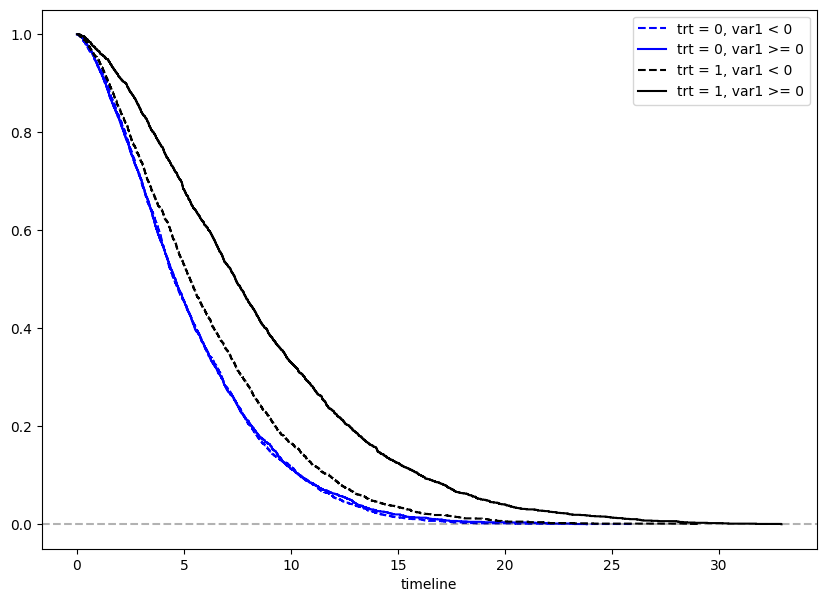

In [26]:
# plot
fig, ax = plt.subplots(1, figsize = (10, 7))

kmf = KaplanMeierFitter()

tmp = df_final.query('trt == 0').query('var1 < 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'blue', alpha = 1, label = 'trt = 0, var1 < 0', ls = '--')

tmp = df_final.query('trt == 0').query('var1 >= 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'blue', alpha = 1, label = 'trt = 0, var1 >= 0')

tmp = df_final.query('trt == 1').query('var1 < 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'black', alpha = 1, label = 'trt = 1, var1 < 0', ls = '--')

tmp = df_final.query('trt == 1').query('var1 >= 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'black', alpha = 1, label = 'trt = 1, var1 >= 0')

plt.axhline(0, color = 'k', ls ='--', alpha = 0.3)
#fig.savefig('10K predictive biomarker slighlty prognostic - var1.png')

Variable 2 is not:

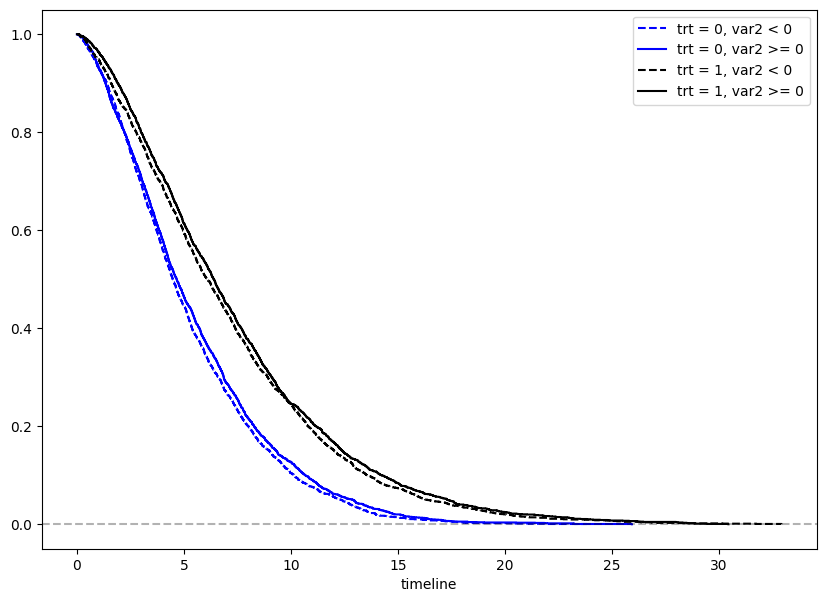

In [37]:
# plot
fig, ax = plt.subplots(1, figsize = (10, 7))

kmf = KaplanMeierFitter()

tmp = df_final.query('trt == 0').query('var2 < 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'blue', alpha = 1, label = 'trt = 0, var2 < 0', ls = '--')

tmp = df_final.query('trt == 0').query('var2 >= 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'blue', alpha = 1, label = 'trt = 0, var2 >= 0')

tmp = df_final.query('trt == 1').query('var2 < 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'black', alpha = 1, label = 'trt = 1, var2 < 0', ls = '--')

tmp = df_final.query('trt == 1').query('var2 >= 0')
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=False, ci_show = False, ax = ax, color = 'black', alpha = 1, label = 'trt = 1, var2 >= 0')

plt.axhline(0, color = 'k', ls ='--', alpha = 0.3)
#fig.savefig('10K predictive biomarker slighlty prognostic - var1.png')